In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
import numpy as np
import warnings; warnings.simplefilter('ignore')
import seaborn as sns
sns.set_palette('Set1')
sns.set_style('white')
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
data_dir = 'C:/Users/mmh/Documents/Data/'
data_dir2 = 'C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/9.Data/'
map_dir = 'C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/8.Maps/'

# Read OD

In [2]:
# read all OD
od = pd.read_feather(data_dir+'OD/GDOT_2019_09.feather')
print(od.memory_usage(index=True).sum())
od = od[~od.origin_zone_id.str.contains("_", na=False)]
od = od[~od.destination_zone_id.str.contains("_", na=False)]
od = od[od.day_type=='Weekday']
print(od.memory_usage(index=True).sum())
od.origin_zone_id = od.origin_zone_id.astype('int64')
od.destination_zone_id = od.destination_zone_id.astype('int64')

cols_dist = ['distance_0_1_pct','distance_1_2.5_pct','distance_2.5_5_pct','distance_5_10_pct',
             'distance_10_25_pct','distance_25_50_pct','distance_50_75_pct','distance_75_100_pct',
             'distance_100_150_pct','distance_150_300_pct','distance_gt300_pct']
dist_mean = [0.5,1.75,3.75,7.5,17.5,37.5,62.5,87.5,125,225,350]

cols = ['origin_zone_id', 'destination_zone_id','total_linked_trips'] + cols_dist
od_dist = od[cols]

od_dist['dist'] = od_dist[cols_dist].mul(dist_mean).sum(1)
od_dist = od_dist[['origin_zone_id', 'destination_zone_id','dist']].rename(columns={'origin_zone_id':'origin', 'destination_zone_id':'destination'})
od_dist.head()

2267953344
2284878240


,origin,destination,dist
0,1005,130039602002,225.0
1,1005,130099702012,225.0
2,1005,130159601031,0.0
3,1005,130159602011,225.0
4,1005,130159604031,225.0


In [3]:
od_long = pd.read_feather(data_dir+'OD/GDOT_2019_09_weekday_car_long.feather')
od_long = od_long.rename(columns={'origin_zone_id':'origin','destination_zone_id':'destination'})
od_long['origin'] = od_long['origin'].astype('int64')
od_long['destination'] = od_long['destination'].astype('int64')
od_long = od_long.sort_values(['origin','destination','hour'])
print(len(od_long))
od_long = pd.merge(od_long,od_dist,how='left',on=['origin','destination'])
print(len(od_long))

od_long['COUNTY_origin'] = od_long['origin'].astype(str).str[:5]
od_long['COUNTY_dest'] = od_long['destination'].astype(str).str[:5]
od_long.loc[od_long.origin==od_long.destination,'dist'] = 0.1

# fillna with 0
od_long['trips'] = od_long['trips'].fillna(0)
od_long['trips'] = od_long['trips'].replace(0,0.1)

od_long.head()

50048040
50048040


,origin,destination,hour,car_share,trips,dist,COUNTY_origin,COUNTY_dest
0,130019501001,130019501001,0,0.632984,14.144894,0.1,13001,13001
1,130019501001,130019501001,1,0.632984,4.848250,0.1,13001,13001
2,130019501001,130019501001,2,0.632984,0.100000,0.1,13001,13001
3,130019501001,130019501001,3,0.632984,0.100000,0.1,13001,13001
4,130019501001,130019501001,4,0.632984,0.100000,0.1,13001,13001


In [4]:
county_intra = od_long.copy()
county_intra['trip_type'] = 'Inter-zonal'
county_intra.loc[county_intra.COUNTY_origin ==county_intra.COUNTY_dest,'trip_type'] = 'Intra-zonal'
county_intra = county_intra.groupby(['COUNTY_origin','trip_type']).agg({'trips':'sum'}).reset_index()
total = county_intra.groupby(['COUNTY_origin']).agg({'trips':'sum'}).reset_index().rename(columns={'trips':'total'})
county_intra = pd.merge(county_intra,total,how='left',on=['COUNTY_origin'])
county_intra['share_true'] = county_intra['trips']/county_intra['total']
county_intra = county_intra[county_intra.trip_type == 'Intra-zonal']
county_intra.head()

,COUNTY_origin,trip_type,trips,total,share_true
1,13001,Intra-zonal,46036.4,57919.0,0.794841
3,13003,Intra-zonal,11100.6,18990.4,0.584537
5,13005,Intra-zonal,30081.3,38471.6,0.781909
7,13007,Intra-zonal,2385.7,4892.3,0.487644
9,13009,Intra-zonal,167623.5,196417.7,0.853403


In [5]:
county_intra[county_intra.COUNTY_origin=='13059']

,COUNTY_origin,trip_type,trips,total,share_true
57,13059,Intra-zonal,463378.1,588575.7,0.787287


# Read data

In [6]:
zone_dir = data_dir+'OD/Clarke County_v3/'
zone_files = os.listdir(zone_dir)
total_vehicles = 0
total_trips = 0
df = pd.DataFrame()
for zone_file in zone_files:
    if zone_file.endswith('.feather'):
        zone_file_path = os.path.join(zone_dir, zone_file)
        trajectory_df = pd.read_feather(zone_file_path)        
        total_vehicles += len(np.unique(trajectory_df.veh_id))
        total_trips += len(trajectory_df.trip_id)
        trajectory_df['zone'] = zone_file
        df = pd.concat([df, trajectory_df])
print(len(df))
print(len(np.unique(df.veh_id)))
df.head()

30591
100


,trip_id,veh_id,start_time,start_zone,purpose,arrival_time,end_zone,distance,avg_speed,stay_time,zone
0,1,1,6.0,130590001001,work,6.048482,130590021002,1.939272,40,4.951518,trip_chain_130590001001.feather
1,2,1,11.0,130590021002,work,11.187500,130591305002,7.500000,40,4.312500,trip_chain_130590001001.feather
2,3,1,15.5,130591305002,home,15.937500,130591405001,17.500000,40,14.062500,trip_chain_130590001001.feather
3,1,2,6.5,130590001001,work,6.527536,130590004022,1.101430,40,10.972464,trip_chain_130590001001.feather
4,2,2,17.5,130590004022,home,17.502500,130590004022,0.100000,40,12.497500,trip_chain_130590001001.feather


In [7]:
df[df.purpose=='home'].stay_time.describe()

count    9862.000000
mean       11.718427
std         7.209045
min        -1.062500
25%         5.312500
50%        12.803041
75%        16.885430
max        23.997500
Name: stay_time, dtype: float64

In [8]:
len(df[df.purpose=='home'])/len(df)

0.32238240005230295

In [9]:
df.groupby(['zone','veh_id']).agg({'distance':'sum'}).mean()

distance    26.616187
dtype: float64

# Trip validation against OD

In [10]:
zone_files = os.listdir(zone_dir)
zone_files
bg_list = [int(file.split("_")[2].split(".")[0]) for file in zone_files]

In [11]:
print("Total Vehicles:", total_vehicles)
print("Total Trips:", total_trips)

Total Vehicles: 8700
Total Trips: 30591


In [12]:
benchmark = od_long[(od_long.origin.isin(bg_list))& (od_long.destination.isin(bg_list))]   
benchmark.trips = benchmark.trips * benchmark.car_share
benchmark.trips.sum()

389678.2942783848

## NHTS & NHTS OD

In [13]:
nhts = pd.read_csv(data_dir2+'nhts/2017/nat_trippub_corr.csv')
nhts = nhts[nhts.HHSTATE=='GA'] # in Georgia
nhts = nhts[nhts['TRPTRANS'].isin([3,4,5,6,8,9,18])] # POV
nhts['numtrips'] = 1
nhts['STRTTIME'] = nhts['STRTTIME'].astype(str).str.zfill(4)
nhts['hour'] = pd.to_numeric(nhts['STRTTIME'].str[0:2])
nhts = nhts.groupby('hour').agg({'numtrips':'sum'}).reset_index()
nhts['NHTS trips'] = nhts['numtrips']/nhts['numtrips'].sum()*100

od_summary = od_long.copy()
od_summary['trips'] = od_summary['trips']*od_summary['car_share']
od_summary = od_summary[(od_summary.origin.isin(bg_list))& (od_summary.destination.isin(bg_list))]  
od_summary = od_summary.groupby('hour').agg({'trips':'sum'}).reset_index()
od_summary['OD trips'] = od_summary['trips']/od_summary['trips'].sum()*100

od_summary = pd.merge(od_summary,nhts,on='hour')
od_summary.head()

,hour,trips,OD trips,numtrips,NHTS trips
0,0,2855.394444,0.732757,103,0.195468
1,1,2527.221289,0.648540,46,0.087296
2,2,2163.232539,0.555133,32,0.060728
3,3,2253.140670,0.578205,17,0.032262
4,4,2572.859912,0.660252,230,0.436482


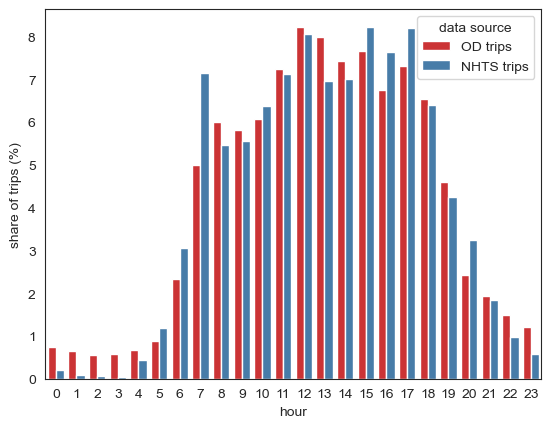

In [14]:
od_melt = od_summary.melt(id_vars='hour', value_vars=['OD trips', 'NHTS trips'], var_name='data source', value_name='trips')
sns.barplot(data=od_melt,x='hour',y='trips',hue='data source')
plt.ylabel('share of trips (%)')
plt.show()

## departure time

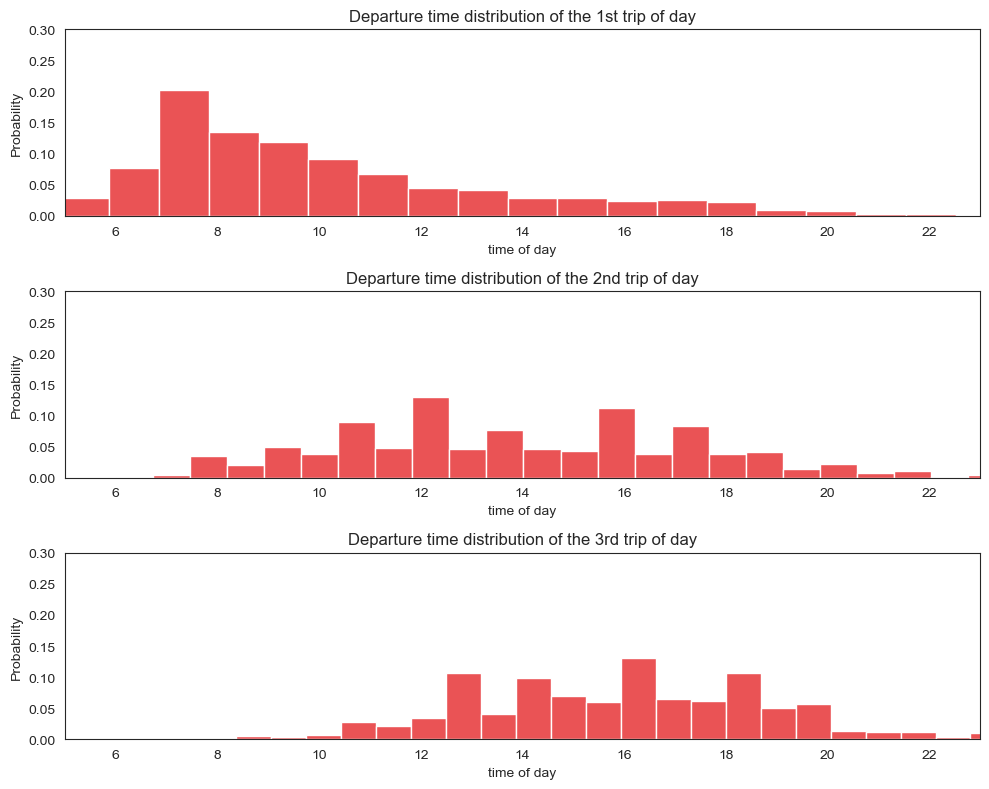

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

plt.subplot(3, 1, 1)
sns.histplot(data=df[df.trip_id == 1], x='start_time', ax=axes[0],stat='probability',bins=24)
axes[0].set_ylim(0, 0.3)
axes[0].set_xlim(5, 23)
plt.xlabel('time of day')
plt.title('Departure time distribution of the 1st trip of day')

plt.subplot(3, 1, 2)
sns.histplot(data=df[df.trip_id == 2], x='start_time', ax=axes[1],stat='probability',bins=24)
axes[1].set_ylim(0, 0.3)
axes[1].set_xlim(5, 23)
plt.xlabel('time of day')
plt.title('Departure time distribution of the 2nd trip of day')

plt.subplot(3, 1, 3)
sns.histplot(data=df[df.trip_id == 3], x='start_time', ax=axes[2],stat='probability',bins=24)
axes[2].set_ylim(0, 0.3)
axes[2].set_xlim(5, 23)
plt.xlabel('time of day')
plt.title('Departure time distribution of the 3rd trip of day')

plt.tight_layout()  # Ensures proper layout of subplots
plt.show()

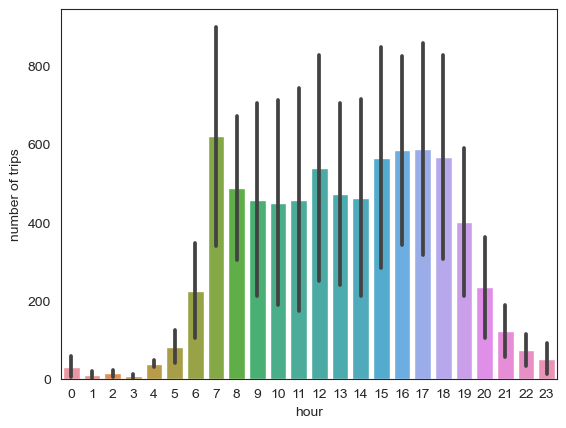

In [16]:
# simulation total out trips
total_estimate = df.copy()
total_estimate['COUNTY_origin'] = total_estimate['start_zone'].astype(str).str[:5]
total_estimate['COUNTY_dest'] = total_estimate['end_zone'].astype(str).str[:5]
total_estimate['hour'] = total_estimate['start_time'].astype(int)

# seelct zones to compare
# total_estimate = total_estimate[(total_estimate.COUNTY_origin=='13059')&(total_estimate.COUNTY_dest=='13059')]
total_estimate = total_estimate[(total_estimate.start_zone.isin(bg_list))& (total_estimate.end_zone.isin(bg_list))] 

total_estimate = total_estimate.groupby(['start_zone','COUNTY_origin','hour','purpose']).agg({'trip_id':'count'}).reset_index()
total_estimate = total_estimate.rename(columns={'start_zone':'origin'})

# calibrate simulation demand
total_estimate['trip_simulation'] = total_estimate['trip_id'] # * total_estimate['base_veh'] /100 * 1.2

total_estimate = total_estimate.groupby(['hour','purpose']).agg({'trip_simulation':'sum'}).reset_index()
sns.barplot(data=total_estimate ,x='hour',y='trip_simulation',errorbar='se') # ,hue='purpose'
plt.ylabel('number of trips')
plt.show()

## Total in trips

In [17]:
# determine base population 
benchmark = od_long[(od_long.COUNTY_origin=='13059')& (od_long.COUNTY_dest=='13059')] #  
benchmark.trips = benchmark.trips * benchmark.car_share
benchmark = benchmark.groupby(['origin','COUNTY_origin']).agg({'trips':'sum'}).reset_index()
benchmark.head()

,origin,COUNTY_origin,trips
0,130590001001,13059,17716.194537
1,130590001002,13059,13968.257068
2,130590004011,13059,10144.383722
3,130590004021,13059,19004.822259
4,130590004022,13059,43117.193519


In [18]:
# nhts
nhts = pd.read_csv(data_dir2+'nhts/2017/nat_trippub_corr.csv')
nhts = nhts[nhts.HHSTATE=='GA'] # in Georgia
nhts = nhts[nhts['TRPTRANS'].isin([3,4,5,6,8,9,18])] # POV
nhts['numtrips'] = 1
print('total trips: '+str(len(nhts)))
persons = nhts.groupby(['HOUSEID','PERSONID']).count()
print('total persons: '+str(len(persons)))
nhts['STRTTIME'] = nhts['STRTTIME'].astype(str).str.zfill(4)
nhts['hour'] = pd.to_numeric(nhts['STRTTIME'].str[0:2])
nhts['minute'] = pd.to_numeric(nhts['STRTTIME'].str[2:4])
nhts['start_time'] = nhts['hour']+nhts['minute']/60
nhts = nhts[~((nhts.WHYFROM==7) | (nhts.WHYTO==7))]
origin_map = {(1,2):'home',(3,4,8):'work',(-9,-8,-7):'not reported'}
d = {k: v for tup, v in origin_map.items() for k in tup}
nhts['purpose'] = nhts['WHYTO'].map(d).fillna('other')
nhts = nhts[~nhts.purpose.isin(['not reported'])]
nhts = nhts[nhts.TRVLCMIN>0]
nhts = nhts.sort_values(['HOUSEID','PERSONID','start_time'])
nhts['rank'] = nhts.groupby(['HOUSEID','PERSONID']).cumcount()+1 # starting from 1
nhts = nhts[nhts['rank'] == 1]

total trips: 52694
total persons: 13526


In [19]:
# determine base population based on census
# bg pop
zone_population = pd.read_csv(data_dir+'Census/ACSDT5Y2019.B01001 GA BG/ACSDT5Y2019.B01001-Data.csv')
zone_population = zone_population.loc[1:,['GEO_ID','B01001_001E']]
zone_population['GEO_ID'] = zone_population['GEO_ID'].str[9:]
zone_population.columns = ['origin','pop']

zone_population['COUNTY_origin'] = zone_population['origin'].str[:5]
zone_population['pop'] = pd.to_numeric(zone_population['pop'])
zone_population['origin'] = pd.to_numeric(zone_population['origin'])
print(len(zone_population))
zone_population.head()

# county pop
county_population = zone_population.groupby('COUNTY_origin').agg({'pop':'sum'}).reset_index()
county_population.head()

# calculate veh
nhts_total = nhts['WTTRDFIN'].sum()/365
nhts_total_059 = nhts_total * county_population.loc[county_population.COUNTY_origin=='13059','pop'].values[0]/county_population['pop'].sum()
bg_base = zone_population[zone_population.COUNTY_origin=='13059']
bg_base['base_veh'] = bg_base['pop']/bg_base['pop'].sum() * nhts_total_059
print('Total number of vehicles: '+str(bg_base['base_veh'].sum()))
bg_base.head()

5533
Total number of vehicles: 83317.6297933865


,origin,pop,COUNTY_origin,base_veh
883,130590001001,2285,13059,1508.851002
884,130590004011,1410,13059,931.063419
885,130590004021,2106,13059,1390.652171
886,130590004022,3506,13059,2315.112304
887,130590004023,2740,13059,1809.300546


### bg (od pair) level

In [125]:
# actual total out trips
# benchmark = od_long[(od_long.COUNTY_origin=='13059')& (od_long.COUNTY_dest=='13059')]  
benchmark = od_long[(od_long.origin.isin(bg_list))& (od_long.destination.isin(bg_list))]  
benchmark.trips = benchmark.trips * benchmark.car_share # * 0.8
benchmark = benchmark.groupby(['origin','destination']).agg({'trips':'sum'}).reset_index()
benchmark.head()

# simulation total out trips
total_estimate = df.copy()
total_estimate['COUNTY_origin'] = total_estimate['start_zone'].astype(str).str[:5]
total_estimate['COUNTY_dest'] = total_estimate['end_zone'].astype(str).str[:5]

# # seelct zones to compare
# total_estimate = total_estimate[total_estimate.start_zone==130591406001]
total_estimate = total_estimate[(total_estimate.start_zone.isin(bg_list))& (total_estimate.end_zone.isin(bg_list))] 

total_estimate = total_estimate.groupby(['start_zone','end_zone']).agg({'trip_id':'count'}).reset_index()
total_estimate = total_estimate.rename(columns={'start_zone':'origin','end_zone':'destination'})

total_estimate = pd.merge(total_estimate,bg_base,on=['origin'])
total_estimate['trip_simulation'] = total_estimate['trip_id'] * total_estimate['base_veh'] * 1.2 /100
total_estimate = pd.merge(total_estimate,benchmark,on=['origin','destination'])
total_estimate['trips'] = total_estimate['trips'].replace(0,1)

total_estimate['diff'] = total_estimate['trip_simulation']/total_estimate['base_veh']-total_estimate['trips']/total_estimate['base_veh']
total_estimate['diff_pct'] = np.abs(total_estimate['diff'])/(total_estimate['trips']/total_estimate['pop'])*100

total_estimate = total_estimate[(total_estimate.trips<=6000)&(total_estimate.trip_simulation<=6000)]
# total_estimate = total_estimate[total_estimate['pop']>0]
total_estimate = total_estimate.sort_values('diff_pct',ascending=False)
print(len(total_estimate))
print(np.sum(total_estimate.trip_simulation))
print(np.sum(total_estimate.trips))
total_estimate.head()

2836
207707.72904097848
232920.33030437023


,origin,destination,trip_id,pop,COUNTY_origin,base_veh,trip_simulation,trips,diff,diff_pct
159,130590004021,130591508004,2,2106,13059,1390.652171,33.375652,1.000000,0.023281,4902.960262
1616,130591305002,130591403003,3,1174,13059,775.225854,27.908131,0.905063,0.034833,4518.288934
1257,130590302002,130591406004,2,1604,13059,1059.167181,25.420012,1.000000,0.023056,3698.160262
1020,130590021001,130590301022,1,3177,13059,2097.864173,25.174370,1.000000,0.011523,3660.960262
1706,130591403002,130590018002,2,1307,13059,863.049567,20.713190,1.000000,0.022841,2985.360262


In [112]:
(232920-207707)/232920*100

10.824746694143911

In [126]:
np.mean(np.abs(total_estimate['diff']))

0.03552928276876617

Text(0.5, 1.0, 'Trip validation for Block Group-Block Group OD trips')

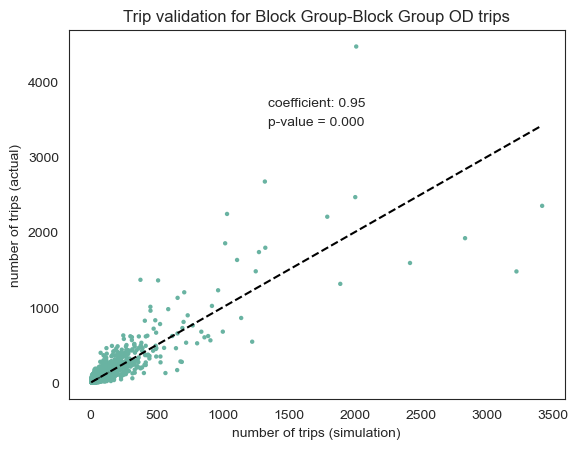

In [99]:
sns.scatterplot(data=total_estimate,x='trip_simulation',y='trips', marker="o",s = 10 ,
                color='#69b3a2',edgecolor='none')
sns.lineplot(data=total_estimate,x='trip_simulation',y='trip_simulation',color='black', linestyle='--')
plt.xlabel('number of trips (simulation)')
plt.ylabel('number of trips (actual)')
from scipy.stats import linregress

# Calculate regression coefficients and p-values
slope, intercept, r_value, p_value, std_err = linregress(total_estimate['trip_simulation'], total_estimate['trips'])
coefficient_text = f"coefficient: {slope:.2f}"
p_value_text = f"p-value = {p_value:.3f}"
plt.text(0.5, 0.8, coefficient_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, 0.75, p_value_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

# plt.xlim(0,1000)
# plt.ylim(0,1000)
plt.title("Trip validation for Block Group-Block Group OD trips")

### hour

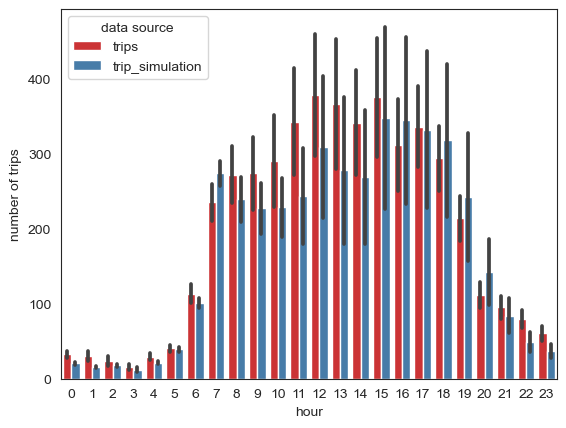

In [100]:
# actual total out trips
# benchmark = od_long[(od_long.COUNTY_origin=='13059')& (od_long.COUNTY_dest=='13059')]  
benchmark = od_long[(od_long.origin.isin(bg_list))& (od_long.destination.isin(bg_list))]  
benchmark.trips = benchmark.trips * benchmark.car_share
benchmark = benchmark.groupby(['origin','COUNTY_origin','hour']).agg({'trips':'sum'}).reset_index()

# simulation total out trips
total_estimate = df.copy()
total_estimate['COUNTY_origin'] = total_estimate['start_zone'].astype(str).str[:5]
total_estimate['COUNTY_dest'] = total_estimate['end_zone'].astype(str).str[:5]
total_estimate['hour'] = total_estimate['start_time'].astype(int)

# seelct zones to compare
# total_estimate = total_estimate[(total_estimate.COUNTY_origin=='13059')&(total_estimate.COUNTY_dest=='13059')]
total_estimate = total_estimate[(total_estimate.start_zone.isin(bg_list))& (total_estimate.end_zone.isin(bg_list))] 

total_estimate = total_estimate.groupby(['start_zone','COUNTY_origin','hour']).agg({'trip_id':'count'}).reset_index()
total_estimate = total_estimate.rename(columns={'start_zone':'origin'})

# calibrate simulation demand
total_estimate = pd.merge(total_estimate,bg_base,on=['origin','COUNTY_origin'])
total_estimate['trip_simulation'] = total_estimate['trip_id'] * total_estimate['base_veh'] /100 * 1.2
total_estimate = pd.merge(total_estimate,benchmark,on=['origin','COUNTY_origin','hour'])

total_estimate['diff'] = total_estimate['trip_simulation']-total_estimate['trips']
total_estimate['diff_pct'] = np.abs(total_estimate['diff'])/total_estimate['trips']*100

total_estimate.head()
total_estimate.sort_values('diff_pct',ascending=False).head(8)

od_melt = total_estimate.melt(id_vars='hour', value_vars=['trips', 'trip_simulation'], var_name='data source', value_name='trips')
sns.barplot(data=od_melt,x='hour',y='trips',hue='data source',errorbar='se')
plt.ylabel('number of trips')
plt.show()

In [121]:
# actual total out trips
# benchmark = od_long[(od_long.COUNTY_origin=='13059')& (od_long.COUNTY_dest=='13059')]  
benchmark = od_long[(od_long.origin.isin(bg_list))& (od_long.destination.isin(bg_list))]  
benchmark.trips = benchmark.trips * benchmark.car_share
benchmark = benchmark.groupby(['origin','COUNTY_origin','hour']).agg({'trips':'sum'}).reset_index()

# simulation total out trips
total_estimate = df.copy()
total_estimate['COUNTY_origin'] = total_estimate['start_zone'].astype(str).str[:5]
total_estimate['COUNTY_dest'] = total_estimate['end_zone'].astype(str).str[:5]
total_estimate['hour'] = total_estimate['start_time'].astype(int)

# seelct zones to compare
# total_estimate = total_estimate[(total_estimate.COUNTY_origin=='13059')&(total_estimate.COUNTY_dest=='13059')]
total_estimate = total_estimate[(total_estimate.start_zone.isin(bg_list))& (total_estimate.end_zone.isin(bg_list))] 

total_estimate = total_estimate.groupby(['start_zone','COUNTY_origin','hour']).agg({'trip_id':'count'}).reset_index()
total_estimate = total_estimate.rename(columns={'start_zone':'origin'})

# calibrate simulation demand
total_estimate = pd.merge(total_estimate,bg_base,on=['origin','COUNTY_origin'])
total_estimate['trip_simulation'] = total_estimate['trip_id'] * total_estimate['base_veh'] /100 * 1.2
total_estimate = pd.merge(total_estimate,benchmark,on=['origin','COUNTY_origin','hour'])

total_estimate = total_estimate.groupby(['hour']).agg({'trip_simulation':'sum','trips':'sum'}).reset_index()
total_estimate['simulation trips'] = total_estimate['trip_simulation']/total_estimate['trip_simulation'].sum()*100
total_estimate['OD trips'] = total_estimate['trips']/total_estimate['trips'].sum()*100

total_estimate['diff'] = total_estimate['simulation trips']-total_estimate['OD trips']
total_estimate['diff_pct'] = np.abs(total_estimate['diff'])/total_estimate['OD trips']*100

# total_estimate = total_estimate[total_estimate.trips<=10000]
total_estimate.sort_values('diff_pct',ascending=False).head(8)

,hour,trip_simulation,trips,simulation trips,OD trips,diff,diff_pct
1,1,314.960926,600.548706,0.128386,0.221289,-0.092903,41.982572
20,20,8092.525904,6345.091763,3.298719,2.338025,0.960694,41.089997
22,22,2138.458538,3499.732005,0.871690,1.289573,-0.417883,32.404766
23,23,1737.126622,2829.962116,0.708097,1.042778,-0.334681,32.095136
0,0,819.462592,1309.129763,0.334034,0.482385,-0.148351,30.753717
7,7,16414.156800,14096.086256,6.690826,5.194093,1.496734,28.816075
19,19,14275.167358,12581.645754,5.818920,4.636055,1.182865,25.514467
16,16,20648.617383,18694.129557,8.416900,6.888369,1.528531,22.190027


18.192475621335458


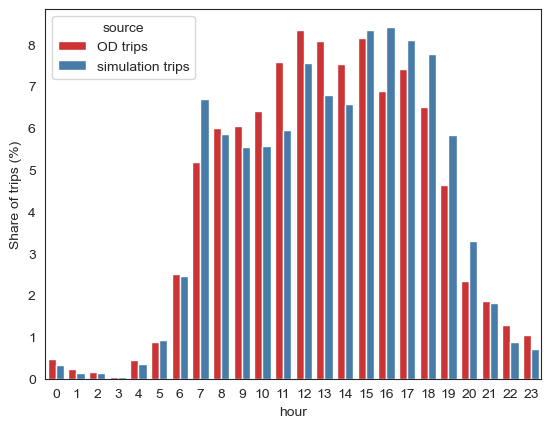

In [122]:
print(np.mean(np.abs(total_estimate['diff_pct'])))
od_melt = total_estimate.melt(id_vars='hour', value_vars=['OD trips', 'simulation trips'], var_name='source', value_name='trips')

sns.barplot(data=od_melt,x='hour',y='trips',hue='source')
plt.ylabel('Share of trips (%)')
plt.show()

### county (origin) level

In [21]:
len(bg_list)

87

In [113]:
# actual total out trips
# benchmark = od_long[(od_long.COUNTY_origin=='13059')& (od_long.COUNTY_dest=='13059')]  
benchmark = od_long[(od_long.origin.isin(bg_list))& (od_long.destination.isin(bg_list))]  
benchmark.trips = benchmark.trips * benchmark.car_share
benchmark = benchmark.groupby(['origin','COUNTY_origin']).agg({'trips':'sum'}).reset_index()
benchmark.head()

# simulation total out trips
total_estimate = df.copy()
total_estimate['COUNTY_origin'] = total_estimate['start_zone'].astype(str).str[:5]
total_estimate['COUNTY_dest'] = total_estimate['end_zone'].astype(str).str[:5]

# seelct zones to compare
# total_estimate = total_estimate[(total_estimate.COUNTY_origin=='13059')&(total_estimate.COUNTY_dest=='13059')]
total_estimate = total_estimate[(total_estimate.start_zone.isin(bg_list))& (total_estimate.end_zone.isin(bg_list))] 

total_estimate = total_estimate.groupby(['start_zone','COUNTY_origin']).agg({'trip_id':'count'}).reset_index()
total_estimate = total_estimate.rename(columns={'start_zone':'origin'})

total_estimate = pd.merge(total_estimate,bg_base,on=['origin','COUNTY_origin'])
# calibrate simulation demand
total_estimate['trip_simulation'] = total_estimate['trip_id'] * total_estimate['base_veh']/100 * 1.2
total_estimate = pd.merge(total_estimate,benchmark,on=['origin','COUNTY_origin'])

# total_estimate['diff'] = total_estimate['trip_simulation']-total_estimate['trips']
total_estimate['diff'] = total_estimate['trip_simulation']/total_estimate['pop']-total_estimate['trips']/total_estimate['pop']
total_estimate['diff_pct'] = np.abs(total_estimate['diff'])/(total_estimate['trips']/total_estimate['pop'])*100

total_estimate = total_estimate[total_estimate.trip_simulation<=15000]
print(total_estimate.base_veh.sum())
total_estimate.sort_values('diff_pct',ascending=False).head(8)

62884.41954479286


,origin,COUNTY_origin,trip_id,pop,base_veh,trip_simulation,trips,diff,diff_pct
38,130591404002,13059,119,1930,1274.434326,1819.892217,445.454538,0.712144,308.547239
9,130590012001,13059,144,2095,1383.388556,2390.495424,1071.076089,0.629794,123.186331
19,130590021001,13059,311,3177,2097.864173,7829.229092,4096.543025,1.174909,91.117951
27,130591303002,13059,135,3325,2195.592815,3556.860361,1977.585263,0.474970,79.858761
48,130591504003,13059,131,602,397.517857,624.898071,2328.511117,-2.829922,73.163191
40,130591406001,13059,140,538,355.256822,596.831462,1890.607180,-2.404788,68.431757
42,130591406003,13059,143,1576,1040.677978,1785.803410,1071.507186,0.453234,66.662756
31,130591305001,13059,131,1163,767.962239,1207.236639,724.388211,0.415175,66.656031


0.9997099003770229
0.5213409997697545


Text(0.5, 1.0, 'Trip validation for Block Group outgoing trips')

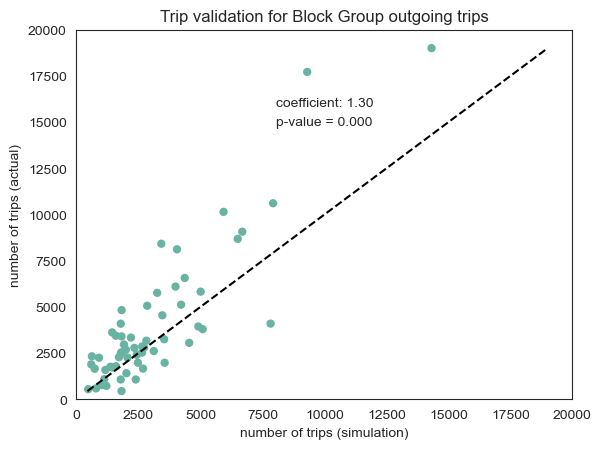

In [104]:
print(total_estimate['diff'].abs().mean())
print(total_estimate['diff'].abs().median())
sns.scatterplot(data=total_estimate,x='trip_simulation',y='trips',color='#69b3a2',edgecolor='none')
sns.lineplot(data=total_estimate,x='trips',y='trips',color='black', linestyle='--')
plt.xlabel('number of trips (simulation)')
plt.ylabel('number of trips (actual)')

# Calculate regression coefficients and p-values
slope, intercept, r_value, p_value, std_err = linregress(total_estimate['trip_simulation'], total_estimate['trips'])
coefficient_text = f"coefficient: {slope:.2f}"
p_value_text = f"p-value = {p_value:.3f}"
plt.text(0.5, 0.8, coefficient_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, 0.75, p_value_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

plt.xlim(0,20000)
plt.ylim(0,20000)
plt.title("Trip validation for Block Group outgoing trips")

In [24]:
total_estimate[total_estimate.trips<1000]

,origin,COUNTY_origin,trip_id,pop,base_veh,trip_simulation,trips,diff,diff_pct
10,130590012002,13059,122,1068,705.231016,860.381839,774.362402,86.019437,11.108421
31,130591305001,13059,131,1163,767.962239,1006.030533,724.388211,281.642321,38.880026
33,130591305003,13059,105,570,376.387340,395.206707,546.608668,-151.401961,27.698419
38,130591404002,13059,119,1930,1274.434326,1516.576848,445.454538,1071.122310,240.456033
44,130591503002,13059,117,849,560.619038,655.924274,590.991599,64.932675,10.987072


### in=out?

Text(0.5, 1.0, 'Block Group incoming and outgoing simulation trips')

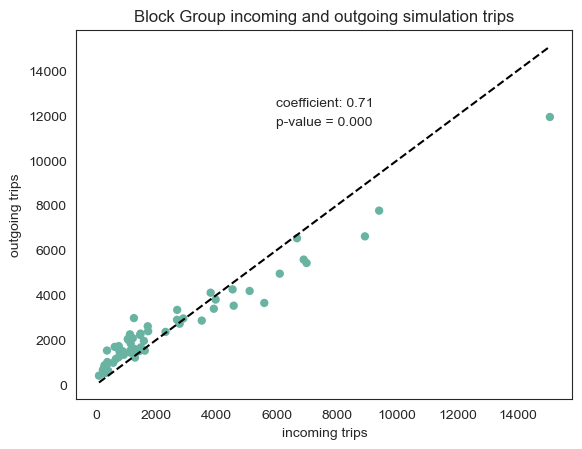

In [110]:
# simulation total out trips
total_estimate = df.copy()
total_estimate['COUNTY_origin'] = total_estimate['start_zone'].astype(str).str[:5]
total_estimate['COUNTY_dest'] = total_estimate['end_zone'].astype(str).str[:5]

# seelct zones to compare
total_estimate = total_estimate[(total_estimate.COUNTY_origin=='13059')&(total_estimate.COUNTY_dest=='13059')]

intrips = total_estimate.groupby(['end_zone','COUNTY_dest']).agg({'trip_id':'count'}).reset_index()
intrips = intrips.rename(columns={'end_zone':'destination'})
outtrips = total_estimate.groupby(['start_zone','COUNTY_origin']).agg({'trip_id':'count'}).reset_index()
outtrips = outtrips.rename(columns={'start_zone':'origin'})
total_estimate = pd.merge(intrips,outtrips,left_on=['destination','COUNTY_dest'],right_on=['origin','COUNTY_origin'])
total_estimate = pd.merge(total_estimate,bg_base,on=['origin'])
total_estimate['trip_id_x'] = total_estimate['trip_id_x'] * total_estimate['base_veh']/100
total_estimate['trip_id_y'] = total_estimate['trip_id_y'] * total_estimate['base_veh']/100
total_estimate.head()

total_estimate = total_estimate[total_estimate.trip_id_x<=20000]
sns.scatterplot(data=total_estimate,x='trip_id_x',y='trip_id_y',color='#69b3a2',edgecolor='none')
sns.lineplot(data=total_estimate,x='trip_id_x',y='trip_id_x',color='black', linestyle='--')
plt.xlabel('incoming trips')
plt.ylabel('outgoing trips')

# Calculate regression coefficients and p-values
slope, intercept, r_value, p_value, std_err = linregress(total_estimate['trip_id_x'], total_estimate['trip_id_y'])
coefficient_text = f"coefficient: {slope:.2f}"
p_value_text = f"p-value = {p_value:.3f}"
plt.text(0.5, 0.8, coefficient_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, 0.75, p_value_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

plt.title("Block Group incoming and outgoing simulation trips")

In [ ]:
print(total_estimate['diff'].abs().mean())
print(total_estimate['diff'].abs().median())
sns.scatterplot(data=total_estimate,x='trip_simulation',y='trips',color='#69b3a2',edgecolor='none')
sns.lineplot(data=total_estimate,x='trips',y='trips',color='black', linestyle='--')
plt.xlabel('number of trips (simulation)')
plt.ylabel('number of trips (actual)')

# Calculate regression coefficients and p-values
slope, intercept, r_value, p_value, std_err = linregress(total_estimate['trip_simulation'], total_estimate['trips'])
coefficient_text = f"coefficient: {slope:.2f}"
p_value_text = f"p-value = {p_value:.3f}"
plt.text(0.5, 0.8, coefficient_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, 0.75, p_value_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

plt.xlim(0,20000)
plt.ylim(0,20000)
plt.title("Trip validation for Block Group outgoing trips")